In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import sys
import matplotlib.pyplot as plt
import numpy as np
import os

### Load the experiment and corresponding libraries

In [2]:
sys.path.append("/")  # enable import of "recipe"
os.chdir("/work/")

In [3]:
from recipes.main import load_experiment
experiment = load_experiment(recipe="_2020_06_23_rewrite", 
                             experiment="test", 
                             schema="anix_nnfabrik_test",  # schema name will automatically be generated from recipe and experiment names 
                             base_dir="/recipes/",
                             import_prefix="recipes.", 
                             dev_mode=True  
                            )

Connecting anix@134.2.168.16:3306


In [4]:
from bias_transfer.tables.trained_model import *
from bias_transfer.tables.trained_transfer_model import *
schema

Connecting anix@134.2.168.16:3306


Schema `anix_nnfabrik_test`

/usr/local/lib/python3.8/dist-packages/datajoint/connection.py:215: UserWarning: MySQL server has gone away. Reconnecting to the server.
  warnings.warn("MySQL server has gone away. Reconnecting to the server.")


model_fn name of the model function,model_hash hash of the model configuration,dataset_fn name of the dataset loader function,dataset_hash hash of the configuration object,trainer_fn name of the Trainer loader function,trainer_hash hash of the configuration object,seed Random seed that is passed to the model- and dataset-builder,comment short description,score loss,output trainer object's output,fabrikant_name Name of the contributor that added this entry,trainedmodel_ts UTZ timestamp at time of insertion


In [5]:
import torch
import numpy as np

In [7]:
from torchvision.datasets import MNIST
from torchvision import transforms

In [9]:
transform = transforms.Compose([
        transforms.ToTensor(),
#         transforms.Normalize((0.1307,), (0.3081,))
        ])
train = MNIST(
            root="/work/",
            train=True,
            download=True,
            transform=transform,
        )

In [137]:
train_set = torch.utils.data.DataLoader(
        train,
        batch_size=64,
        shuffle=True,
    )
train_batch = next(iter(train_set))
train_batch, batch_targets = train_batch[0].numpy(), train_batch[1].numpy()
train_batch.shape

(64, 1, 28, 28)

In [250]:
def plot_batch(batch, targets, n_rows,n_cols, name="", file_type="png"):
    batch = batch.transpose(0,2,3,1)
    fig, axs = plt.subplots(n_rows,n_cols)
    if n_rows == 1:
        axs= [axs]
    for r in range(n_rows):
        for c in range(n_cols):
            axs[r][c].imshow(batch[r*n_cols+c].squeeze())
            axs[r][c].set_title(targets[r*n_cols+c])
            axs[r][c].set_axis_off()
    plt.show()
    if name:
        fig.savefig(
            name + "." + file_type,
            facecolor=fig.get_facecolor(),
            edgecolor=fig.get_edgecolor(),
            bbox_inches="tight",
        )

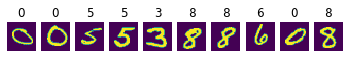

In [245]:
plot_batch(train_batch, batch_targets, 1, 10, name="standard_mnist")

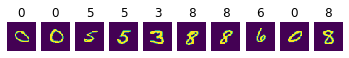

In [243]:
# 40x40 to follow https://www.cs.toronto.edu/~tijmen/affNIST/ for translation
def apply_expansion(batch, targets):
    orig_shape = batch.shape
    expanded_batch = np.zeros((orig_shape[0],1,40,40))
    expanded_batch[:,:,6:-6,6:-6] = batch
    return expanded_batch, targets
expanded_batch, _ = apply_expansion(train_batch, batch_targets)
plot_batch(expanded_batch, batch_targets, 1, 10, name="expanded_mnist")

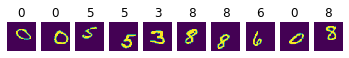

In [242]:
def apply_translation(batch, targets, std=5):
    offsets = np.clip(np.random.normal(scale=std, size=batch.shape[0]*2),a_min=-6,a_max=6)
    offsets = offsets.astype(np.int)
    x_offset, y_offset = offsets[:batch.shape[0]], offsets[batch.shape[0]:]
    for b in range(batch.shape[0]):
        batch[b,0,:,:] = np.roll(batch[b,0,:,:],(y_offset[b],x_offset[b]), axis=(0,1)) 
    return batch, targets
translated_batch, _ = apply_translation(expanded_batch.copy(), batch_targets)
plot_batch(translated_batch, batch_targets, 1,10, name="translated_mnist")

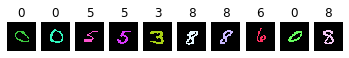

In [241]:
# code adapted from https://github.com/salesforce/corr_based_prediction/blob/master/gen_color_mnist.py
# procedure following https://arxiv.org/pdf/1812.10352.pdf
# they variaed color_variance between 0.05 and 0.02 (in 0.005 steps)

# generate color codes
class_color_means =[
    [60,180,75],  # green
    [255,255,25],  # yellow
    [0,130,200],  # blue
    [245,130,48],  # orange
    [70,240,240],  # cyan
    [240,50,230],  # magenta
    [230,25,75],  # red
    [0,0,128],  # navy
    [220,190,255],  # lavender
    [255,250,200],  # beige
]
nb_classes = 10
def get_color_codes():
#     C = np.random.rand(nb_classes,3)
    C = np.asarray(class_color_means)
    C = C/np.max(C, axis=1)[:,None]
    return C

def get_std_color(means, targets, var):
    mean = means[targets].reshape((-1))
    cov = var * np.eye(mean.shape[0])
    c = np.random.multivariate_normal(mean=mean,cov=cov)
    c = c.reshape(targets.shape[0], 3, 1, 1)
    return c
    
def apply_color(x, targets, cfg_means=None, cbg_means=None, fg=True, bg=False, color_variance=0.0):
    assert len(x.shape)==4, 'Something is wrong, size of input x should be 4 dimensional (B x C x H x W; perhaps number of channels is degenrate? If so, it should be 1)'
    bs = targets.shape[0]
    xs = x.shape
    
    x = (((x*255)>150)*255).astype(np.float)  # thresholding to separate fg and bg
    x_rgb = np.ones((xs[0],3, xs[2], xs[3])).astype(np.float)
    x_rgb = x_rgb* x
    if fg:
        x_rgb_fg = 1.*x_rgb
        x_rgb_fg *= get_std_color(cfg_means, targets, color_variance)
    else:
        x_rgb_fg = np.zeros_like(x_rgb)
    if bg:
        x_rgb_bg = (255-x_rgb)
        x_rgb_bg *= get_std_color(cbg_means, targets, color_variance)
    else:
        x_rgb_bg = np.zeros_like(x_rgb)
    x_rgb = x_rgb_fg + x_rgb_bg
    x_rgb = np.clip(x_rgb, a_min=0.,a_max=255.)
    color_data_x = x_rgb/255.
    return color_data_x, targets

colored_batch, _ = apply_color(expanded_batch, batch_targets, cfg_means=get_color_codes(), 
                                     cbg_means=get_color_codes(), bg=False, fg=True, color_variance=0.02)
plot_batch(colored_batch, batch_targets, 1,10, name="colored_mnist")

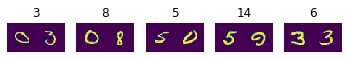

In [240]:
def generate_addition_data(batch, targets):
    second_summand = np.arange(batch.shape[0])
    np.random.shuffle(second_summand)
    concat_batch = np.concatenate([batch,batch[second_summand]],axis=3) 
    summed_targets = targets + targets[second_summand]
    return concat_batch, summed_targets
add_batch, add_target = generate_addition_data(expanded_batch, batch_targets)
plot_batch(add_batch, add_target, 1,5, name="summed_mnist")

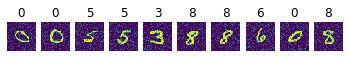

In [239]:
# adapted from https://github.com/google-research/mnist-c
def apply_gaussian_noise(batch, targets, severity=1):
    c = [.08, .12, 0.18, 0.26, 0.38][severity - 1]
    return np.clip(batch + np.random.normal(size=batch.shape, scale=c), 0, 1) * 255, targets
noisy_batch, _ = apply_gaussian_noise(expanded_batch, batch_targets, severity=3)
plot_batch(noisy_batch, batch_targets, 1,10, "noisy_mnist")

In [247]:
def generate_dataset(transform_fs=(), options=()):
    transform = transforms.Compose([
        transforms.ToTensor(),
        ])
    train = MNIST(
                root="/work/data/image_classification/torchvision/",
                train=True,
                download=True,
                transform=transform,
    )  
    train_loader = torch.utils.data.DataLoader(
        train,
        batch_size=64,
        shuffle=False,
    )
    new_ds_source = []
    new_ds_target = []
    for source, target in train_loader:
        source = source.detach().numpy()
        target = target.detach().numpy()
        for t, transform_f in enumerate(transform_fs):
            source, target = transform_f(source, target, **options[t])
        new_ds_source.append(source)
        new_ds_target.append(target)
    return new_ds_source, new_ds_target

ds = generate_dataset(transform_fs=(apply_expansion,apply_gaussian_noise), options=({},{}))
            

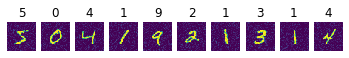

In [252]:
plot_batch(ds[0][0], ds[1][0], 1,10)